## Import libraries

In [4]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import cv2
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling1D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

[]

## Get data from datasets:

In [24]:
main_path = r'C:\Users\kumar_lf3uub3\Desktop\Emotion Recognition\Speech'
TESS = os.path.join(main_path, "Tess\TESS Toronto emotional speech set data/")
RAV = os.path.join(main_path, "Ravdess/")
SAVEE = os.path.join(main_path, "Savee\ALL/")

dir_list = os.listdir(SAVEE)
dir_list[0:5]

['DC_a01.wav', 'DC_a02.wav', 'DC_a03.wav', 'DC_a04.wav', 'DC_a05.wav']

### RAVDESS dataset

In [25]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(RAV)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            # X, sample_rate = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
           
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[19:20])
            
            # arr = mfccs, lab
            # lst.append(arr)
            
            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) #only labels
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)
            
            full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

0it [00:00, ?it/s]

In [26]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
emotions_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])


In [27]:
df.head()

,emotion,voc_channel,modality,intensity,actors,phrase,path
0,neutral,speech,audio only,normal,male,Kids are talking by the door,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
1,neutral,speech,audio only,normal,male,Kids are talking by the door,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
2,neutral,speech,audio only,normal,male,Dogs are sitting by the door,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
3,neutral,speech,audio only,normal,male,Dogs are sitting by the door,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
4,calm,speech,audio only,normal,male,Kids are talking by the door,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...


### SAVEE

In [28]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('angry_male')
    elif i[-8:-6]=='_d':
        emotion.append('disgust_male')
    elif i[-8:-6]=='_f':
        emotion.append('fear_male')
    elif i[-8:-6]=='_h':
        emotion.append('happy_male')
    elif i[-8:-6]=='_n':
        emotion.append('neutral_male')
    elif i[-8:-6]=='sa':
        emotion.append('sad_male')
    elif i[-8:-6]=='su':
        emotion.append('surprise_male')
    else:
        emotion.append('Unknown') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['emotion_label'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.emotion_label.value_counts()

neutral_male     120
angry_male        60
disgust_male      60
fear_male         60
happy_male        60
sad_male          60
surprise_male     60
Name: emotion_label, dtype: int64

In [29]:
SAVEE_df.head()

,emotion_label,source,path
0,angry_male,SAVEE,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
1,angry_male,SAVEE,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
2,angry_male,SAVEE,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
3,angry_male,SAVEE,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
4,angry_male,SAVEE,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...


### TESS dataset

In [30]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry_female')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('disgust_female')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('fear_female')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy_female')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral_female')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('surprise_female')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad_female')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.emotion_label.value_counts()

fear_female        400
surprise_female    400
sad_female         400
angry_female       400
disgust_female     400
happy_female       400
neutral_female     400
Unknown             14
Name: emotion_label, dtype: int64

In [31]:
TESS_df.head()

,emotion_label,source,path
0,fear_female,TESS,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
1,fear_female,TESS,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
2,fear_female,TESS,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
3,fear_female,TESS,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
4,fear_female,TESS,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...


### Combining the datasets:

In [32]:
RAV_df = df.copy()

# only speech
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

RAV_df.insert(0, "emotion_label", RAV_df.emotion+'_'+RAV_df.actors, True)
RAV_df.insert(1, "source", "RAV", True)
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)
RAV_df.head()

,emotion_label,source,actors,path
0,neutral_male,RAV,male,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
1,neutral_male,RAV,male,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
2,neutral_male,RAV,male,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
3,neutral_male,RAV,male,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...
4,calm_male,RAV,male,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...


In [33]:
TESS_df.insert(2, "actors", "female", True)
SAVEE_df.insert(2, "actors", "male", True)

In [34]:
SAVEE_df['emotion_label'].unique()

array(['angry_male', 'disgust_male', 'fear_male', 'happy_male',
       'neutral_male', 'sad_male', 'surprise_male'], dtype=object)

In [35]:
df_combined = pd.concat([TESS_df, RAV_df, SAVEE_df])
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6174 entries, 0 to 479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion_label  6174 non-null   object
 1   source         6174 non-null   object
 2   actors         6174 non-null   object
 3   path           6174 non-null   object
dtypes: object(4)
memory usage: 241.2+ KB


In [36]:
for col in ['emotion_label', 'source', 'actors']:
    print('\nColumn values for ', col.upper())
    print(df_combined[col].value_counts())


Column values for  EMOTION_LABEL
sad_female          592
angry_female        592
disgust_female      592
happy_female        592
neutral_female      496
fear_female         400
surprise_female     400
disgust_male        252
angry_male          252
sad_male            252
happy_male          252
neutral_male        216
calm_male           192
fearful_male        192
surprised_male      192
calm_female         192
fearful_female      192
surprised_female    192
fear_male            60
surprise_male        60
Unknown              14
Name: emotion_label, dtype: int64

Column values for  SOURCE
RAV      2880
TESS     2814
SAVEE     480
Name: source, dtype: int64

Column values for  ACTORS
female    4254
male      1920
Name: actors, dtype: int64


In [37]:
new_labels_dict_comb = {'angry_male':'negative_male', 'angry_female':'negative_female', 
                        'calm_male':'neutral_male', 'calm_female':'neutral_female',
                        'disgust_male':'negative_male', 'disgust_female':'negative_female', 
                        'fearful_male':'negative_male','fearful_female':'negative_female',
                        'fear_male':'negative_male', 'fear_female':'negative_female',
                        'happy_male':'positive_male', 'happy_female':'positive_female',
                        'neutral_male':'neutral_male', 'neutral_female':'neutral_female',
                        'sad_male':'negative_male', 'sad_female':'negative_female',
                        'surprised_male':'positive_male', 'surprised_female':'positive_female',
                        'surprise_male':'positive_male', 'surprise_female':'positive_female',
                        'Unknown': 'unk'}

df_combined['emotion2'] = df_combined['emotion_label'].map(new_labels_dict_comb)
df_combined.head()

,emotion_label,source,actors,path,emotion2
0,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female
1,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female
2,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female
3,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female
4,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female


In [38]:
addit_labels_dict_comb = {'angry_male':'angry', 'angry_female':'angry', 
                        'calm_male':'neutral', 'calm_female':'neutral',
                        'disgust_male':'negative', 'disgust_female':'negative', 
                        'fearful_male':'fear','fearful_female':'fear',
                        'fear_male':'fear', 'fear_female':'fear',
                        'happy_male':'positive', 'happy_female':'positive',
                        'neutral_male':'neutral', 'neutral_female':'neutral',
                        'sad_male':'sadness', 'sad_female':'sadness',
                        'surprised_male':'surprise', 'surprised_female':'surprise',
                        'surprise_male':'surprise', 'surprise_female':'surprise',
                        'Unknown': 'unk'}

df_combined['emotion3'] = df_combined['emotion_label'].map(addit_labels_dict_comb)
df_combined.head()

,emotion_label,source,actors,path,emotion2,emotion3
0,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear
1,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear
2,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear
3,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear
4,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear


In [39]:
df_combined.emotion2.value_counts()

negative_female    2368
positive_female    1184
negative_male      1008
neutral_female      688
positive_male       504
neutral_male        408
unk                  14
Name: emotion2, dtype: int64

In [40]:
df_combined.emotion3.value_counts()

neutral     1096
fear         844
surprise     844
sadness      844
angry        844
negative     844
positive     844
unk           14
Name: emotion3, dtype: int64

In [41]:
df_combined = df_combined.loc[df_combined['emotion2'] != 'unk']

### Save the data:

In [42]:
df_combined.to_csv(os.path.join(main_path,"combined.csv"), index=False)

### (Using the combined DF, MFCC's and column 'emotion2' as target)

In [45]:
import pickle

df_path = r"C:\Users\kumar_lf3uub3\Desktop\Emotion Recognition\Speech\combined.csv"
# mfccs_path = 'd://itc//final_project//mfccs.pickle'
# new_y_path = 'd://itc//final_project//y.pickle'

# with open('d://downloads//y.pickle', 'wb') as f:
#     pickle.dump(new_y, f)
    
# with open('d://downloads//mfccs.pickle', 'wb') as f:
#     pickle.dump(mfccs, f)

mydf = pd.read_csv(df_path)

# with open(mfccs_path, 'rb') as f:
#     mfccs = pickle.load(f)

# with open(new_y_path, 'rb') as f:
#     new_y = pickle.load(f)

### EDA

In [46]:
mydf.head()

,emotion_label,source,actors,path,emotion2,emotion3
0,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear
1,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear
2,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear
3,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear
4,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear


In [47]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6160 entries, 0 to 6159
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion_label  6160 non-null   object
 1   source         6160 non-null   object
 2   actors         6160 non-null   object
 3   path           6160 non-null   object
 4   emotion2       6160 non-null   object
 5   emotion3       6160 non-null   object
dtypes: object(6)
memory usage: 288.9+ KB


In [56]:
import matplotlib.pyplot as plt
import librosa.display

In [ ]:
# import soundfile as sf
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming you have 'mydf' DataFrame and 'ind' index defined
# ind = np.random.randint(0,len(mydf))
# # Load audio data and sampling rate using soundfile
# data, sampling_rate = sf.read(mydf['path'][ind])

# # Get emotion label
# emotion = mydf['emotion2'][ind]

# # Plot the sound wave
# plt.figure(figsize=(10, 4))
# plt.title(f'Sound wave of- {emotion}')
# plt.plot(np.arange(len(data)) / sampling_rate, data)
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.show()

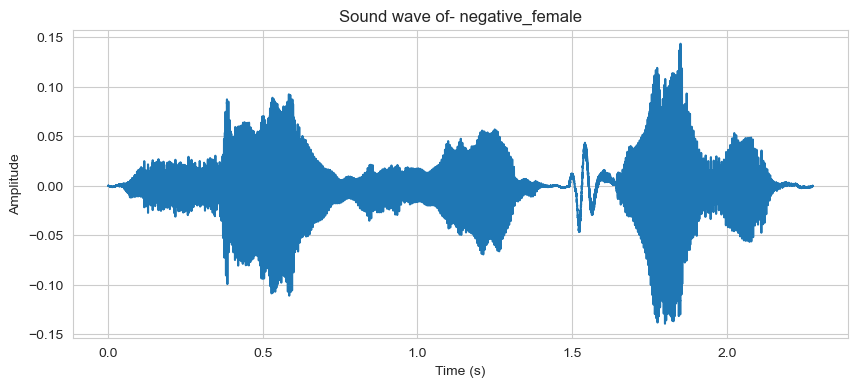

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have 'data' and 'sampling_rate' defined
plt.figure(figsize=(10, 4))
plt.title(f'Sound wave of- {emotion}')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


In [60]:
# ind = np.random.randint(0,len(mydf))
# data, sampling_rate = librosa.load(mydf['path'][ind], sr=44100)
# emotion = mydf['emotion2'][ind]

# plt.title(f'Sound wave of- {emotion}')
# librosa.display.waveplot(data, sampling_rate)
# plt.show()

#### Linear-scale spectrum

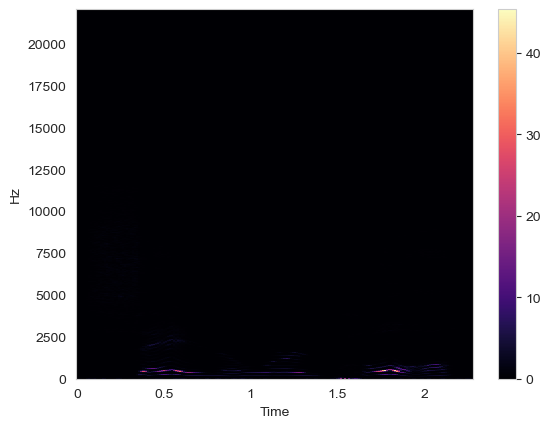

In [61]:
D = np.abs(librosa.stft(data))
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='linear');
plt.colorbar()
plt.show()

#### Log-scale Spectrogram

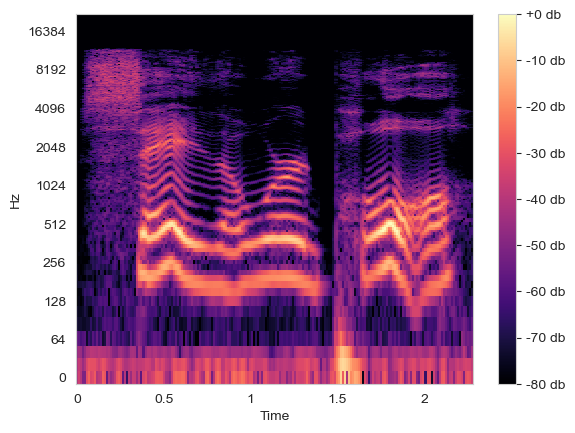

In [62]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sampling_rate, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f db')
plt.show()

#### Log-scale spectrum

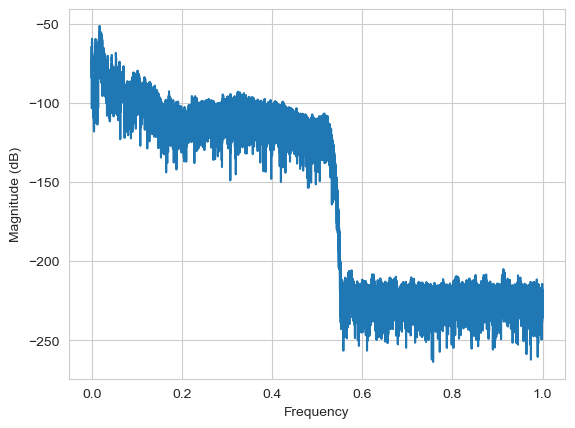

In [63]:
a = plt.magnitude_spectrum(data, scale='dB')
plt.show()

In [64]:
a1 = np.log(a[0])
a2 = a[1]

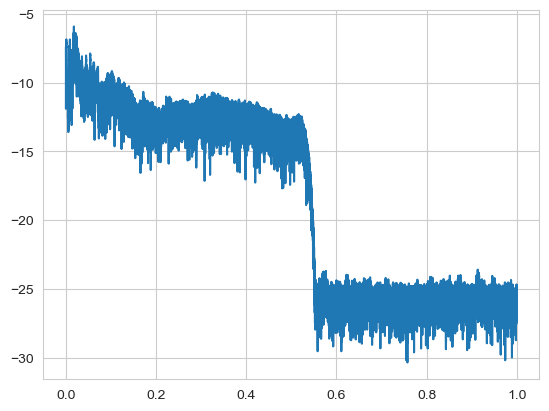

In [65]:
plt.plot(a2,a1)
plt.show()

In [66]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """

    # locals min      
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
    

    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s) 
        # pre-sorting of locals min based on relative position with respect to s_mid 
        lmin = lmin[s[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid 
        lmax = lmax[s[lmax]>s_mid]


    # global max of dmax-chunks of locals max 
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global min of dmin-chunks of locals min 
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    
    return lmin,lmax

In [67]:
data.shape

(100451,)

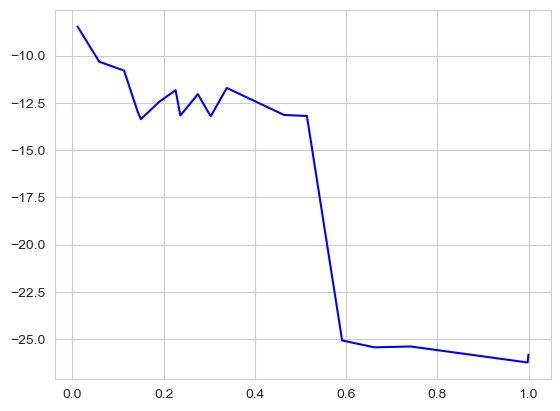

In [68]:
high_idx, _ = hl_envelopes_idx(data[:len(a1)], dmin=250)

# plot
plt.plot(a2[high_idx], a1[high_idx], 'b', label='low')
plt.show()

### Create DF from MFCC's and 'emotion2' columns as labels

In [69]:
new_y = mydf['emotion2'].copy()

In [70]:
X = []
for i in tqdm(mydf['path']):
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

  0%|          | 0/6160 [00:00<?, ?it/s]

In [71]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

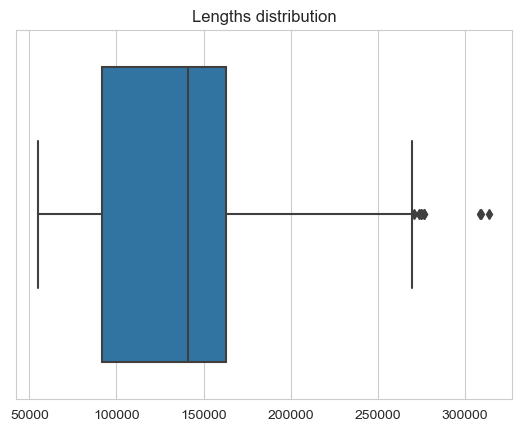

In [72]:
lengths = [len(x) for x in new_x]

plt.title('Lengths distribution')
sns.boxplot(lengths)
plt.show()

In [73]:
thresh = 300000

3


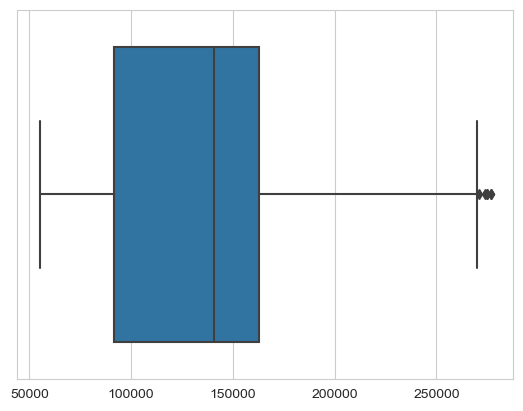

In [74]:
lengths = np.array(lengths)
print((lengths > thresh).sum())
new_lengths = lengths[lengths < thresh]

sns.boxplot(new_lengths)
plt.show()

In [75]:
new_lengths.mean()

130307.0690271236

In [76]:
length_chosen = 120378

In [79]:
import math

X_new = []
y_new = []
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
            
        y_new.append(new_y[ind])
            

In [81]:
X = np.array(X_new,dtype=object)
y = np.array(y_new)
print(X.shape, y.shape)

(6157,) (6157,)


In [82]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=20)
    mfcc = mfcc.T
    mfccs.append(mfcc)


  0%|          | 0/6157 [00:00<?, ?it/s]

In [83]:
mfccs = np.array(mfccs)

In [84]:
mydf.shape, mfccs.shape, y.shape

((6160, 6), (6157, 236, 20), (6157,))

### Save the data:

In [87]:
mfccs_path = r'C:\Users\kumar_lf3uub3\Desktop\Emotion Recognition\Speech\mfccs.pickle'
y_path = r'C:\Users\kumar_lf3uub3\Desktop\Emotion Recognition\Speech\y.pickle'

with open(mfccs_path, 'wb') as f:
    pickle.dump(mfccs,f)
    
with open(y_path, 'wb') as f:
    pickle.dump(y,f)

# BASELINE MODEL

### At this point, we can perform a normal classification, using our mfccs coefficients as our features.

In [88]:
# random:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mfccs, y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4925, 236, 20), (1232, 236, 20), (4925,), (1232,))


### We'll change the values in our target variable and expand the dimension of our features to fit the neural networks.

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

model = Sequential(
    [
     layers.Conv1D(64, 3, activation='relu', input_shape=(236,20)),
     layers.MaxPooling1D(),
     layers.Conv1D(64, 3, activation='relu'),
     layers.MaxPooling1D(),
     layers.Conv1D(64, 3, activation='relu'),
     layers.MaxPooling1D(),
     layers.Flatten(),
     layers.Dense(64, activation="relu"),
     layers.Dense(6, activation="softmax")
    ]
)


In [90]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 234, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 117, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 115, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 57, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 55, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 27, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1728)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         110,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,654 (545.52 KB)

 Trainable params: 139,654 (545.52 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
model.input_shape, model.output_shape

((None, 236, 20), (None, 6))

### Encoding the labels:

In [92]:
set(y)

{'negative_female',
 'negative_male',
 'neutral_female',
 'neutral_male',
 'positive_female',
 'positive_male'}

In [93]:
emotions_encode = {'negative_female':0, 'negative_male':1, 'neutral_female':2, 'neutral_male':3,
                  'positive_female':4, 'positive_male':5}

In [94]:
y_train = pd.Series(y_train).map(emotions_encode)
y_test = pd.Series(y_test).map(emotions_encode)

In [96]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.4932 - loss: 5.3421 - val_accuracy: 0.7386 - val_loss: 0.5720
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7788 - loss: 0.4916 - val_accuracy: 0.8060 - val_loss: 0.4193
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8321 - loss: 0.3848 - val_accuracy: 0.8255 - val_loss: 0.3916
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8610 - loss: 0.3488 - val_accuracy: 0.8287 - val_loss: 0.4017
Epoch 5/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8989 - loss: 0.2632 - val_accuracy: 0.8442 - val_loss: 0.3645
Epoch 6/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9293 - loss: 0.1879 - val_accuracy: 0.8506 - val_loss: 0.3524
Epoch 7/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9192 - loss: 0.2011 - val_accuracy: 0.8929 - val_loss: 0.2810
Epoch 8/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9388 - loss: 0.1608 - val_acc

In [97]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred]
print(classification_report(y_test, y_pred, target_names = list(emotions_encode.keys())))

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
                 precision    recall  f1-score   support

negative_female       0.99      0.98      0.98       490
  negative_male       0.89      0.82      0.85       217
 neutral_female       1.00      0.99      1.00       106
   neutral_male       0.73      0.91      0.81        79
positive_female       0.95      0.99      0.97       237
  positive_male       0.85      0.83      0.84       103

       accuracy                           0.94      1232
      macro avg       0.90      0.92      0.91      1232
   weighted avg       0.94      0.94      0.94      1232



In [98]:
mydf['emotion2'].unique()

array(['negative_female', 'positive_female', 'neutral_female',
       'neutral_male', 'positive_male', 'negative_male'], dtype=object)

In [99]:
import tensorflow as tf

model2 = Sequential()

model2.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(236,20)))
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling1D(pool_size=(8)))
model2.add(layers.Dropout(0.1))

model2.add(layers.Conv1D(128, 5,padding='same'))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.1))

model2.add(layers.Flatten())
model2.add(layers.Dense(6))
model2.add(layers.Activation('softmax'))

model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 236, 256)            │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 236, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 29, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 29, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 29, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 29, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 29, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3712)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │          22,278 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 6)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,102 (828.52 KB)

 Trainable params: 212,102 (828.52 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, 
                                              verbose=1)

weight_path = r'C:\Users\kumar_lf3uub3\Desktop\Emotion Recognition\Speech\best_weights.weights.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)


In [106]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train, y_train, batch_size=16, epochs=36, validation_data=(X_test, y_test),
           callbacks=[reduce_lr, early_stop, model_checkpoint])

Epoch 1/36
308/308 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.3679 - loss: 10.9434 - val_accuracy: 0.6396 - val_loss: 0.9650 - learning_rate: 0.0010
Epoch 2/36
308/308 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6096 - loss: 0.9664 - val_accuracy: 0.6721 - val_loss: 0.8394 - learning_rate: 0.0010
Epoch 3/36
308/308 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6952 - loss: 0.7444 - val_accuracy: 0.7232 - val_loss: 0.6274 - learning_rate: 0.0010
Epoch 4/36
308/308 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7145 - loss: 0.6510 - val_accuracy: 0.7573 - val_loss: 0.5208 - learning_rate: 0.0010
Epoch 5/36
308/308 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7537 - loss: 0.5627 - val_accuracy: 0.7516 - val_loss: 0.5741 - learning_rate: 0.0010
Epoch 6/36
308/308 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7742 - loss: 0.5086 - val_accuracy: 0.7881 - val_loss: 0.4518 - learning_rate: 0.0010
Epoch 7/36
308/308 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7890 - 

In [109]:
model2.load_weights(r'C:\Users\kumar_lf3uub3\Desktop\Emotion Recognition\Speech\best_weights.weights.h5')

In [110]:
y_pred = model2.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred]
print(classification_report(y_test, y_pred, target_names = list(emotions_encode.keys())))

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
                 precision    recall  f1-score   support

negative_female       0.99      0.99      0.99       490
  negative_male       0.85      0.86      0.86       217
 neutral_female       0.99      1.00      1.00       106
   neutral_male       0.79      0.86      0.82        79
positive_female       0.98      0.98      0.98       237
  positive_male       0.83      0.76      0.79       103

       accuracy                           0.94      1232
      macro avg       0.91      0.91      0.91      1232
   weighted avg       0.94      0.94      0.94      1232



## Classifiy emotions- first we'll need to create new MFCC's and target arrays:

In [111]:
mydf['emotion3'].unique()

array(['fear', 'surprise', 'sadness', 'angry', 'negative', 'positive',
       'neutral'], dtype=object)

In [112]:
# mydf['emotion3'].replace(['fear_female', 'fear_male'], 'fear', inplace=True)
# mydf['emotion3'].replace(['surprise_female', 'surprise_male'], 'surprise', inplace=True)
# mydf['emotion3'].replace(['sad_female', 'sad_male'], 'sadness', inplace=True)
# mydf['emotion3'].replace(['negative_female', 'negative_male'], 'negetive', inplace=True)
# mydf['emotion3'].replace(['positive_female', 'positive_male'], 'positive', inplace=True)
# mydf['emotion3'].replace(['neutral_female', 'neutral_male'], 'neutral', inplace=True)

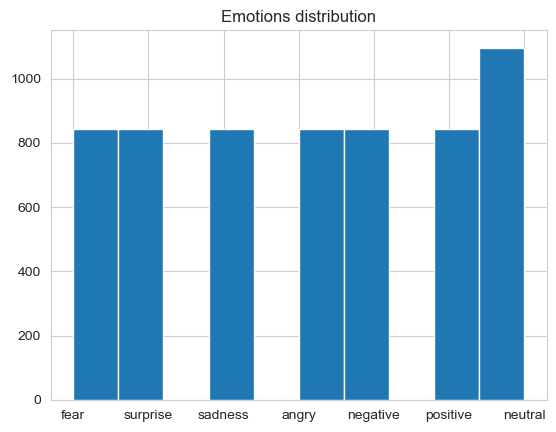

In [113]:
plt.title('Emotions distribution')
plt.hist(mydf['emotion3'])
# plt.hist(y)
plt.show()

In [114]:
y = mydf['emotion3'].copy()

In [115]:
mydf.head()

,emotion_label,source,actors,path,emotion2,emotion3
0,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear
1,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear
2,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear
3,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear
4,fear_female,TESS,female,C:\Users\kumar_lf3uub3\Desktop\Emotion Recogni...,negative_female,fear


In [116]:
y.shape

(6160,)

In [117]:
X = []
for i in tqdm(mydf['path']):
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

  0%|          | 0/6160 [00:00<?, ?it/s]

In [118]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

In [119]:
lengths = [len(x) for x in new_x]

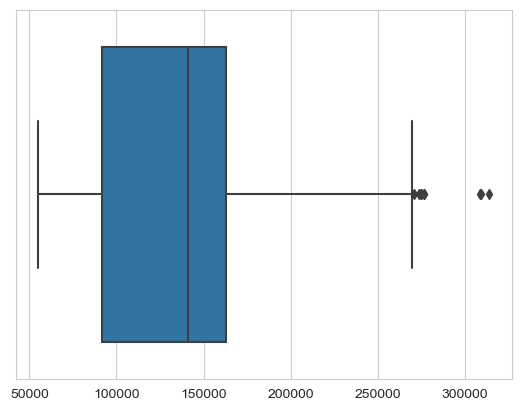

In [120]:
sns.boxplot(lengths)
plt.show()

3


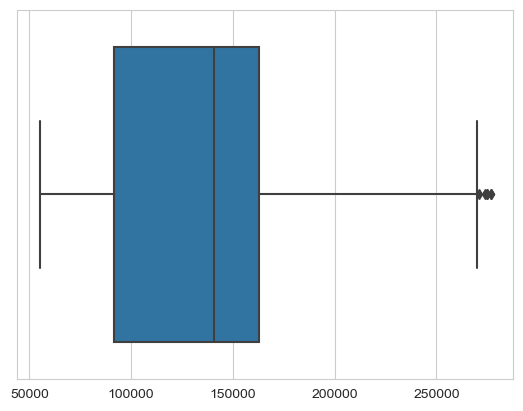

In [121]:
lengths = np.array(lengths)
print((lengths > 300000).sum())
new_lengths = lengths[lengths < 300000]

sns.boxplot(new_lengths)
plt.show()

In [122]:
print(new_lengths.mean())

130307.0690271236


In [123]:
length_chosen = 120378

In [124]:
import math

X_new = []
y_new = []
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
            
        y_new.append(y[ind])
            

In [127]:
X = np.array(X_new, dtype=object)
y = np.array(y_new)
print(X.shape, y.shape)

(6157,) (6157,)


In [128]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=40)
    mfcc = mfcc.T
    mfccs.append(mfcc)


  0%|          | 0/6157 [00:00<?, ?it/s]

In [129]:
mfccs = np.array(mfccs)
mfccs.shape

(6157, 236, 40)

In [130]:
set(y)

{'angry', 'fear', 'negative', 'neutral', 'positive', 'sadness', 'surprise'}

### Save new data:

In [132]:
import pickle 

mfccs2_path = r'C:\Users\kumar_lf3uub3\Desktop\Emotion Recognition\Speech\mfccs2.pickle'
y2_path = r'C:\Users\kumar_lf3uub3\Desktop\Emotion Recognition\Speech\y2.pickle'

with open(mfccs2_path, 'wb') as f:
    pickle.dump(mfccs,f)
    
with open(y2_path, 'wb') as f:
    pickle.dump(y,f)
    
with open(mfccs2_path, 'rb') as f:
    mfccs = pickle.load(f)
    
with open(y2_path, 'rb') as f:
    y = pickle.load(f)

In [133]:
set(y)

{'angry', 'fear', 'negative', 'neutral', 'positive', 'sadness', 'surprise'}

In [134]:
y = np.where(y=='positive', 'happy', y)
y = np.where(y=='negative', 'disgust', y)

In [135]:
emotion_enc = {'fear':0, 'disgust':1, 'neutral':2, 'happy':3, 'sadness':4, 'surprise':5, 'angry':6}

In [136]:
X_train, X_val, y_train, y_val = train_test_split(mfccs, y, test_size=0.2, random_state=12)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=15)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((4925, 236, 40), (616, 236, 40), (616, 236, 40), (4925,), (616,), (616,))

In [137]:
y_train = pd.Series(y_train).map(emotion_enc)
y_val = pd.Series(y_val).map(emotion_enc)
y_test = pd.Series(y_test).map(emotion_enc)

In [139]:
y_train.unique(), y_test.unique(), y_val.unique()

(array([5, 3, 6, 1, 4, 2, 0], dtype=int64),
 array([6, 0, 2, 3, 4, 5, 1], dtype=int64),
 array([2, 6, 5, 4, 3, 0, 1], dtype=int64))

In [140]:
model3 = Sequential()

model3.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(236,40)))
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling1D(pool_size=(8)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv1D(128, 5,padding='same'))
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling1D(pool_size=(4)))
model3.add(layers.Dropout(0.1))

model3.add(layers.Flatten())
model3.add(layers.Dense(64))
model3.add(layers.Dense(7))
model3.add(layers.Activation('softmax'))

model3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 236, 256)            │          51,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 236, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 29, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 29, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 29, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 29, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 896)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          57,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             455 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 7)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 273,287 (1.04 MB)

 Trainable params: 273,287 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [141]:
# weight_path2 = 'd://ITC//final_project_data//best_weights3.hdf5'
weight_path2 = r'C:\Users\kumar_lf3uub3\Desktop\Emotion Recognition\Speech\best_weights2.weights.h5'

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1)

model_checkpoint2 = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path2, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)


In [143]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.fit(X_train, y_train, batch_size=16, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, model_checkpoint2])

Epoch 1/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.2833 - loss: 26.5334 - val_accuracy: 0.4935 - val_loss: 1.3778 - learning_rate: 0.0010
Epoch 2/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.4922 - loss: 1.3807 - val_accuracy: 0.5244 - val_loss: 1.2964 - learning_rate: 0.0010
Epoch 3/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.5587 - loss: 1.1758 - val_accuracy: 0.6088 - val_loss: 1.0163 - learning_rate: 0.0010
Epoch 4/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.6207 - loss: 1.0026 - val_accuracy: 0.5909 - val_loss: 1.0639 - learning_rate: 0.0010
Epoch 5/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.6360 - loss: 0.9993 - val_accuracy: 0.6299 - val_loss: 1.0024 - learning_rate: 0.0010
Epoch 6/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.6599 - loss: 0.9110 - val_accuracy: 0.6331 - val_loss: 0.9671 - learning_rate: 0.0010
Epoch 7/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.

Epoch 42/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9412 - loss: 0.1612 - val_accuracy: 0.9042 - val_loss: 0.3787 - learning_rate: 2.5000e-04
Epoch 43/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9504 - loss: 0.1447 - val_accuracy: 0.9123 - val_loss: 0.3588 - learning_rate: 2.5000e-04
Epoch 44/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9544 - loss: 0.1285 - val_accuracy: 0.9026 - val_loss: 0.3590 - learning_rate: 2.5000e-04
Epoch 45/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9609 - loss: 0.1162 - val_accuracy: 0.9091 - val_loss: 0.3642 - learning_rate: 2.5000e-04
Epoch 46/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9577 - loss: 0.1273 - val_accuracy: 0.9091 - val_loss: 0.3805 - learning_rate: 2.5000e-04
Epoch 47/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9575 - loss: 0.1145 - val_accuracy: 0.9188 - val_loss: 0.3722 - learning_rate: 2.5000e-04
Epoch 48/500
308/308 ━━━━━━━━━━━━━━━━━━━

Epoch 80/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9932 - loss: 0.0193 - val_accuracy: 0.9286 - val_loss: 0.3733 - learning_rate: 1.0000e-05
Epoch 81/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9920 - loss: 0.0257 - val_accuracy: 0.9269 - val_loss: 0.3708 - learning_rate: 1.0000e-05
Epoch 82/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9905 - loss: 0.0306 - val_accuracy: 0.9302 - val_loss: 0.3717 - learning_rate: 1.0000e-05
Epoch 83/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9928 - loss: 0.0221 - val_accuracy: 0.9286 - val_loss: 0.3827 - learning_rate: 1.0000e-05
Epoch 84/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9920 - loss: 0.0316 - val_accuracy: 0.9269 - val_loss: 0.3795 - learning_rate: 1.0000e-05
Epoch 85/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9930 - loss: 0.0237 - val_accuracy: 0.9253 - val_loss: 0.3826 - learning_rate: 1.0000e-05
Epoch 86/500
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 2

In [144]:
# model3.load_weights(weight_path2)

## Transfer learning

In [145]:
# pretrained_model = tf.keras.applications.DenseNet201(include_top=False, 
#                                                      weights='imagenet', 
#                                                      input_shape=(236,40,3))
# # pretrained_model.trainable = False
# for layer in pretrained_model.layers:
#   if 'conv5' in layer.name:
#     layer.trainable = True
#   else:
#     layer.trainable = False

# pretrained_model.input_shape, pretrained_model.output_shape

In [146]:
# X_train.shape

In [147]:
# X_train_expand = np.expand_dims(X_train, 3)
# X_test_expand = np.expand_dims(X_test, 3)

In [148]:
# X_train_expand.shape, X_test_expand.shape

In [149]:
# before_model = Sequential()

# before_model.add(layers.Conv1D(256, 5,padding='same',
#                  input_shape=(236,40,1)))
# before_model.add(layers.Activation('relu'))
# before_model.add(layers.Dropout(0.2))
# # before_model.add(layers.UpSampling2D(size=2))
# before_model.add(layers.Dense(64))
# before_model.add(layers.Dense(3))

# before_model.summary()

In [150]:
# after_model = tf.keras.models.Sequential()
# after_model.add(before_model)
# after_model.add(pretrained_model)
# after_model.add(tf.keras.layers.GlobalAveragePooling2D())
# after_model.add(tf.keras.layers.Flatten())

# after_model.add(tf.keras.layers.Dense(256))
# after_model.add(tf.keras.layers.Dropout(0.2))

# after_model.add(tf.keras.layers.Dense(128))
# after_model.add(tf.keras.layers.Dropout(0.1))
# after_model.add(tf.keras.layers.Dense(6, activation='softmax'))

# after_model.summary()

In [151]:
# after_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
# after_model.fit(X_train_expand, y_train, batch_size=32, epochs=500, validation_data=(X_test_expand, y_test),
#            callbacks=[reduce_lr, early_stop, model_checkpoint2])

### Final evaluation:

In [152]:
def report_res_and_plot_matrix(y_test, y_pred, plot_classes):

  #report metrics
  acc = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {acc:.4f}")
  # print(f"Classes: {plot_classes}")

  #plot matrix
  cnf_matrix = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots()
    
  tick_marks = np.arange(len(plot_classes))
  plt.xticks(ticks=tick_marks, labels=plot_classes, rotation=90)
  plt.yticks(ticks=tick_marks, labels=plot_classes, rotation=90)

  group_counts = [f'{value:0.0f}' for value in cnf_matrix.flatten()]
  group_percentages = [f'{100 * value:0.1f} %' for value in 
                       cnf_matrix.flatten()/np.sum(cnf_matrix)]
  labels = [f'{v1}\n({v2})' for v1, v2 in
            zip(group_counts,group_percentages)]
  n = int(np.sqrt(len(labels)))
  labels = np.asarray(labels).reshape(n,n)
  sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues',
              xticklabels=plot_classes, yticklabels=plot_classes)


  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

  # return metrics
  return [acc, cnf_matrix]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

        fear       0.89      0.94      0.92        90
     disgust       0.93      0.95      0.94        85
     neutral       0.95      0.99      0.97        97
       happy       0.94      0.94      0.94        90
     sadness       0.94      0.88      0.91        76
    surprise       0.97      0.91      0.94        94
       angry       0.95      0.94      0.95        84

    accuracy                           0.94       616
   macro avg       0.94      0.94      0.94       616
weighted avg       0.94      0.94      0.94       616

Accuracy: 0.9399


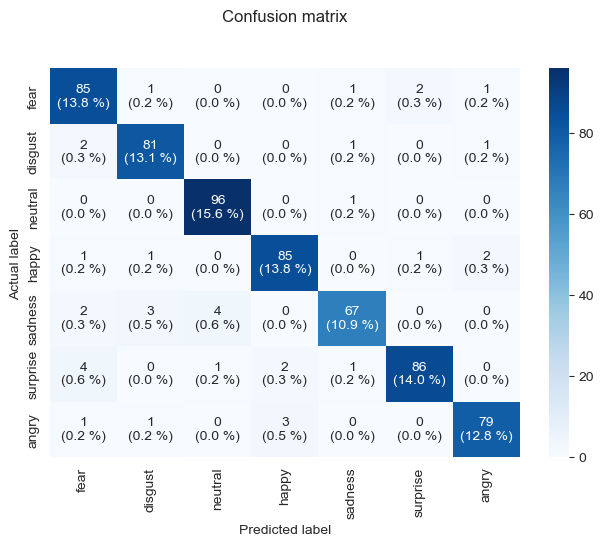

In [153]:
from sklearn.metrics import classification_report

y_pred = model3.predict(X_test).argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=list(emotion_enc.keys())))
params = report_res_and_plot_matrix(y_test, y_pred, list(emotion_enc.keys()))

### Visualization of our classes

In [154]:
X_test.shape, X_train.shape, y_pred.shape

((616, 236, 40), (4925, 236, 40), (616,))

In [157]:
X_test_new = X_test.reshape(616,-1).copy()
X_train_new = X_train.reshape(4925,-1).copy()

In [158]:
X_test_new.shape, X_train_new.shape

((616, 9440), (4925, 9440))

In [159]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(X_train_new)
X_train_scaled = scaler.transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)


In [160]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit_transform(X_train_scaled)
X_pca = pca.transform(X_test_scaled)


In [161]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=0).fit(X_pca)
labels = kmeans.labels_

In [162]:
set(labels)

{0, 1, 2, 3, 4, 5, 6}

### Figuring out which label resambles which class:

In [163]:
set(y_pred)

{0, 1, 2, 3, 4, 5, 6}

In [164]:
l = pd.get_dummies(labels)
p = pd.get_dummies(y_pred)

l.shape, p.shape

((616, 7), (616, 7))

In [168]:
h = pd.merge(l, p, left_index=True, right_index=True)

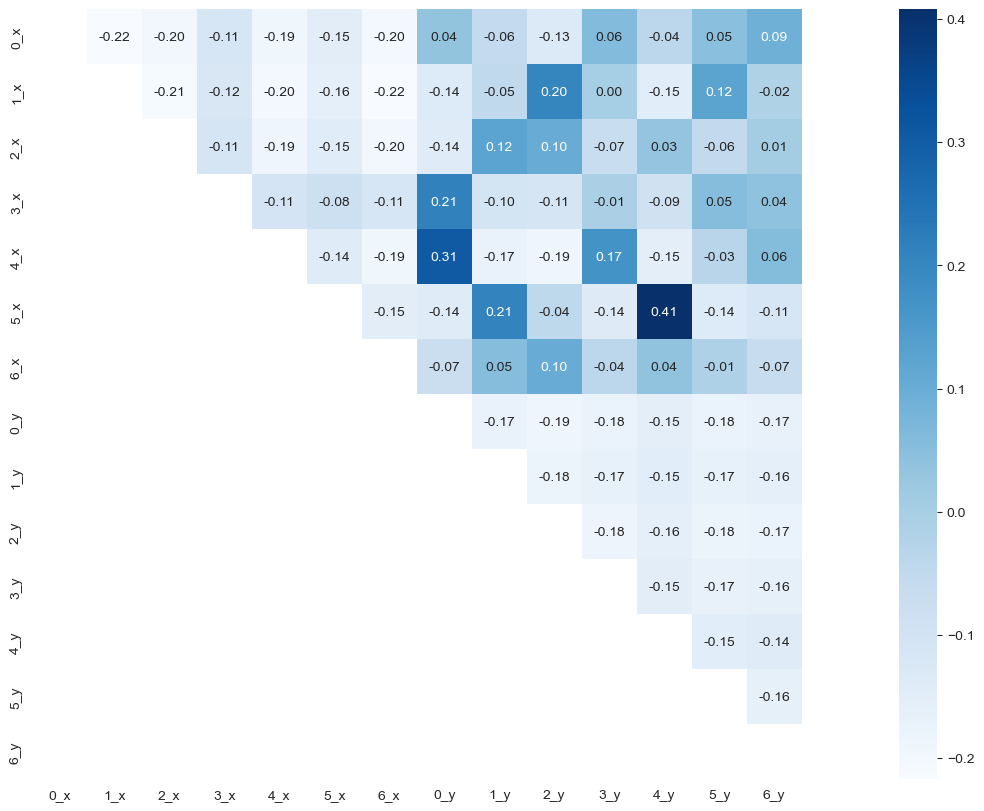

In [170]:
corr = h.corr(method='spearman')
mask = np.tril(np.ones_like(corr, dtype=bool))
ax = plt.figure(figsize=(25,10))
ax = sns.heatmap(h.corr(method='spearman'), annot=True, fmt=".2f", mask = mask, square = True, cmap="Blues")

In [171]:
a = pd.DataFrame(labels)
b= pd.DataFrame(y_pred)
c= pd.DataFrame()
c['labels'] = a[0].copy()
c['preds'] = b[0].copy()

In [172]:
c.head()

,labels,preds
0,1,6
1,6,0
2,2,2
3,0,3
4,0,0


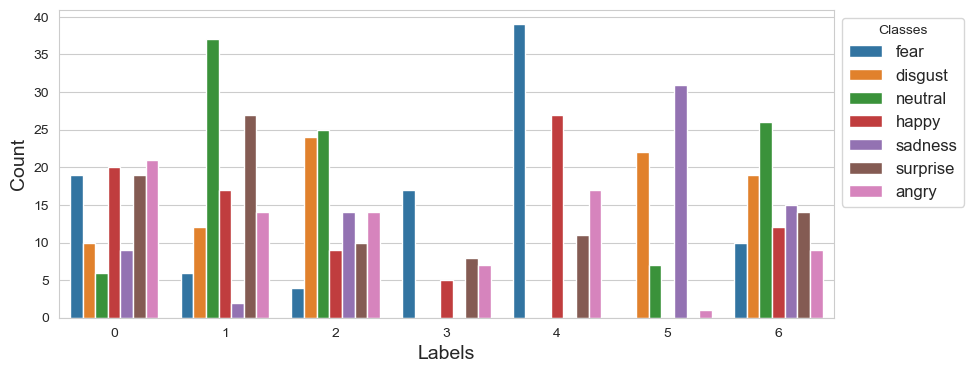

In [173]:
plt.figure(figsize=(10,4))
sns.countplot(x='labels', hue="preds", data=c)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Classes', bbox_to_anchor = (1,1), labels=list(emotion_enc.keys()), fontsize='large')
plt.show()

### Corresponding classes:

- label 0 - class 5
- label 1 - class 2
- label 2 - class 1
- label 3 - class 3
- label 4 - class 6
- label 5 - class 0
- label 6 - class 4


In [174]:
emotion_enc

{'fear': 0,
 'disgust': 1,
 'neutral': 2,
 'happy': 3,
 'sadness': 4,
 'surprise': 5,
 'angry': 6}

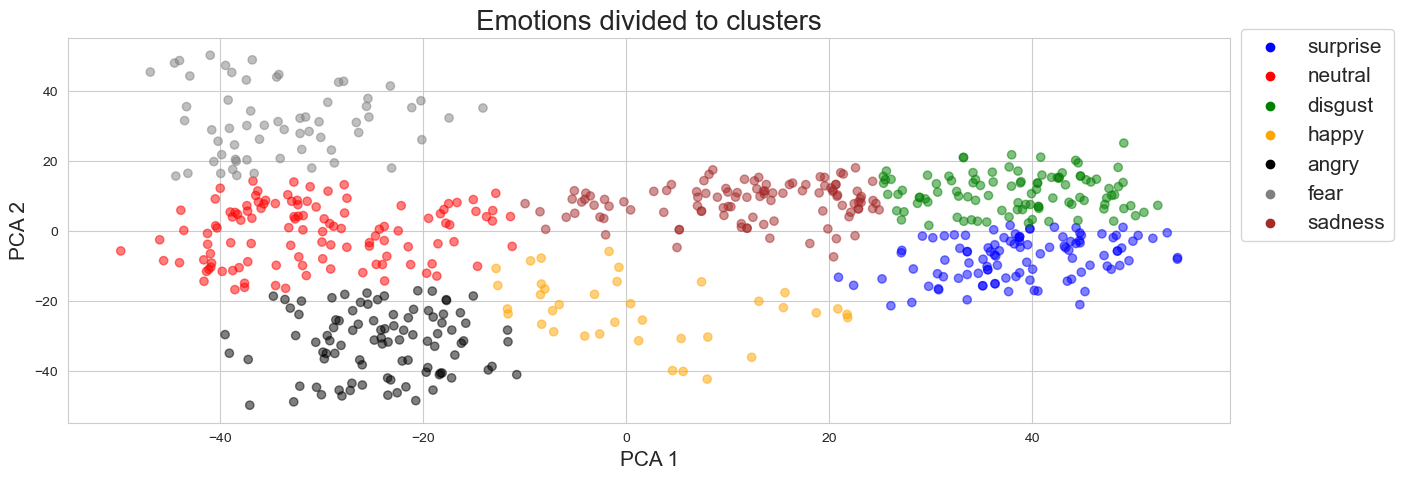

In [175]:
colors = {0:'blue', 1:'red', 2:'green', 3:'orange', 4:'black', 5:'grey', 6:'brown'}
lab = ['surprise', 'neutral', 'disgust', 'happy', 'angry', 'fear', 'sadness']


fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(111)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c = pd.Series(labels).map(colors), alpha=0.5)
for i in range(7):
    plt.scatter(None, None, color=colors[i], label=lab[i])

plt.title('Emotions divided to clusters', fontsize=20)
plt.legend(fontsize=15, bbox_to_anchor= [1, 1.05])
plt.xlabel('PCA 1', fontsize=15)
plt.ylabel('PCA 2', fontsize=15)
plt.show()

Save models:

In [177]:
import tensorflow as tf

model2.save(r'C:\Users\kumar_lf3uub3\Desktop\Emotion Recognition\Speech\model2.h5')
model3.save(r'C:\Users\kumar_lf3uub3\Desktop\Emotion Recognition\Speech\model3.h5')

model3 = tf.keras.models.load_model(r'C:\Users\kumar_lf3uub3\Desktop\Emotion Recognition\Speech\model3.h5')

In [178]:
emotion_enc

{'fear': 0,
 'disgust': 1,
 'neutral': 2,
 'happy': 3,
 'sadness': 4,
 'surprise': 5,
 'angry': 6}

#### Check random samples from dataset

In [180]:
x,sr = librosa.load(r"C:\Users\kumar_lf3uub3\Desktop\Emotion Recognition\Speech\result.wav",
             res_type='kaiser_fast', sr=44000)

In [181]:
x.shape, length_chosen

((840840,), 120378)

In [182]:
if x.shape[0] > length_chosen:
        new = x[:length_chosen]
elif x.shape[0] < length_chosen:
        new = np.pad(x,math.ceil((length_chosen-x.shape[0])/2), mode='median')
else:
        new = x



In [183]:
mfcc = librosa.feature.mfcc(y=new, sr=44000, n_mfcc=40)
mfcc = mfcc.T
mfcc.shape

(236, 40)

In [184]:
mfcc = mfcc.reshape(1,236,40)
mfcc.shape
p = model3.predict(mfcc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


In [185]:
p.argmax()

6

In [188]:
emotion_enc

{'fear': 0,
 'disgust': 1,
 'neutral': 2,
 'happy': 3,
 'sadness': 4,
 'surprise': 5,
 'angry': 6}

# Testing

In [192]:
import librosa
import numpy as np
import math

# Load a new audio file
new_audio_file = r"C:\Users\kumar_lf3uub3\Desktop\Emotion Recognition\Speech\Ravdess\Actor_01\03-01-04-02-02-01-01.wav"  # Change this to the path of your new audio file
x, sr = librosa.load(new_audio_file, res_type='kaiser_fast', sr=44000)

# Define length_chosen
length_chosen = 120378

# Pad or truncate audio data to match length_chosen
if x.shape[0] > length_chosen:
    new = x[:length_chosen]
elif x.shape[0] < length_chosen:
    pad_width = math.ceil((length_chosen - x.shape[0]) / 2)
    new = np.pad(x, (pad_width, pad_width), mode='median')
else:
    new = x

# Extract MFCC features
mfcc = librosa.feature.mfcc(y=new, sr=44000, n_mfcc=40)
mfcc = mfcc.T

# Reshape MFCC features
mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])

# Make prediction
p = model3.predict(mfcc)

# Define emotion labels
emotion_labels = {
    0: 'fear',
    1: 'disgust',
    2: 'neutral',
    3: 'happy',
    4: 'sadness',
    5: 'surprise',
    6: 'angry'
}

# Calculate softmax probabilities for each class
probabilities = np.exp(p) / np.sum(np.exp(p), axis=-1)

# Get predicted emotion with maximum probability
predicted_emotion_index = np.argmax(probabilities)
predicted_emotion = emotion_labels[predicted_emotion_index]

# Get probability of correctness for each class
correctness_probabilities = probabilities[0]

# Output the predicted emotion with its corresponding probability
print("Predicted emotion:", predicted_emotion)
print("Probabilities:")
for emotion_idx, emotion_label in emotion_labels.items():
    print(f"{emotion_label}: {correctness_probabilities[emotion_idx] * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted emotion: sadness
Probabilities:
fear: 11.48%
disgust: 11.47%
neutral: 11.47%
happy: 11.48%
sadness: 31.15%
surprise: 11.47%
angry: 11.47%
